In [295]:
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import talib
import pandas as pd
import plotly.graph_objects as go
import numpy as np

df = yf.download("2379.TW", start="2021-01-01", end="2021-07-16")

[*********************100%***********************]  1 of 1 completed


In [296]:
sma5 = pd.DataFrame()
sma5['sma5'] = talib.SMA(df['Adj Close'], timeperiod=5)
sma20 = pd.DataFrame()
sma20['sma20'] = talib.SMA(df['Adj Close'], timeperiod=20)

In [297]:
def ohlc_plot(Data, name):
    BAR_WIDTH = 8
    plt.figure(figsize=(20,10))
    for i in range(len(Data)): 
        plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 2], ymax = Data.iloc[i, 1], 
                   color = 'black', linewidth = 1)

        if Data.iloc[i, 0] > Data.iloc[i, 3]:
            color_Data = 'green'
            plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 3], ymax = Data.iloc[i, 0], 
                       color = color_Data, linewidth = BAR_WIDTH)              
        elif Data.iloc[i, 0] < Data.iloc[i, 3]:
            color_Data = 'red'
            plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 0], ymax = Data.iloc[i, 3], 
                       color = color_Data, linewidth = BAR_WIDTH)  
        else:
            color_Data = 'black'
            plt.vlines(x = Data.index[i], ymin = Data.iloc[i, 0], ymax = Data.iloc[i, 3], 
                       color = color_Data, linewidth = BAR_WIDTH)  
          
    plt.grid()
    plt.title(name)
    
# 尋找買賣點的函數
def buy_sell(df):
    '''
    df[0]：short SMA
    df[1]：long SMA
    df[2]：close price
    '''
    signal_buy = []  # 買點價格
    signal_sell = [] # 賣點價格
    
    # 買賣點旗標
    # 1：短期超過長期為買點
    # 0：短期超過長期為賣點
    # -1：表非買賣點
    flag=-1          
    
    # 掃描每一筆資料
    for index, row in df.iterrows():
        # 短期超過長期：買
        if row[df.columns[0]] > row[df.columns[1]]:
            if flag != 1: # 之前的短期未超過長期，即黃金交叉
                signal_buy.append(row[df.columns[2]])
                signal_sell.append(np.nan)
                flag=1
            else: # 非買賣點
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        # 長期超過短期：賣
        elif row[df.columns[0]] < row[df.columns[1]]:
            if flag != 0: # 之前的長期未超過短期，即死亡交叉
                signal_buy.append(np.nan)
                signal_sell.append(row[df.columns[2]])
                flag=0
            else: # 非買賣點
                signal_buy.append(np.nan)
                signal_sell.append(np.nan)
        else: # 非買賣點
            signal_buy.append(np.nan)
            signal_sell.append(np.nan)
    return (signal_buy, signal_sell)

In [298]:
# 合併短期與長期移動平均線
df_new = sma5.copy()
df_new['sma20'] = sma20['sma20']
df_new['adjclose'] = df['Adj Close']
signal_buy, signal_sell = buy_sell(df_new)
# 買點
df_buy = pd.DataFrame({'date': df.index, 'signal_buy':signal_buy})
df_buy = df_buy[~np.isnan(signal_buy)]

# 賣點
df_sell = pd.DataFrame({'date': df.index, 'signal_sell':signal_sell})
df_sell = df_sell[~np.isnan(signal_sell)]


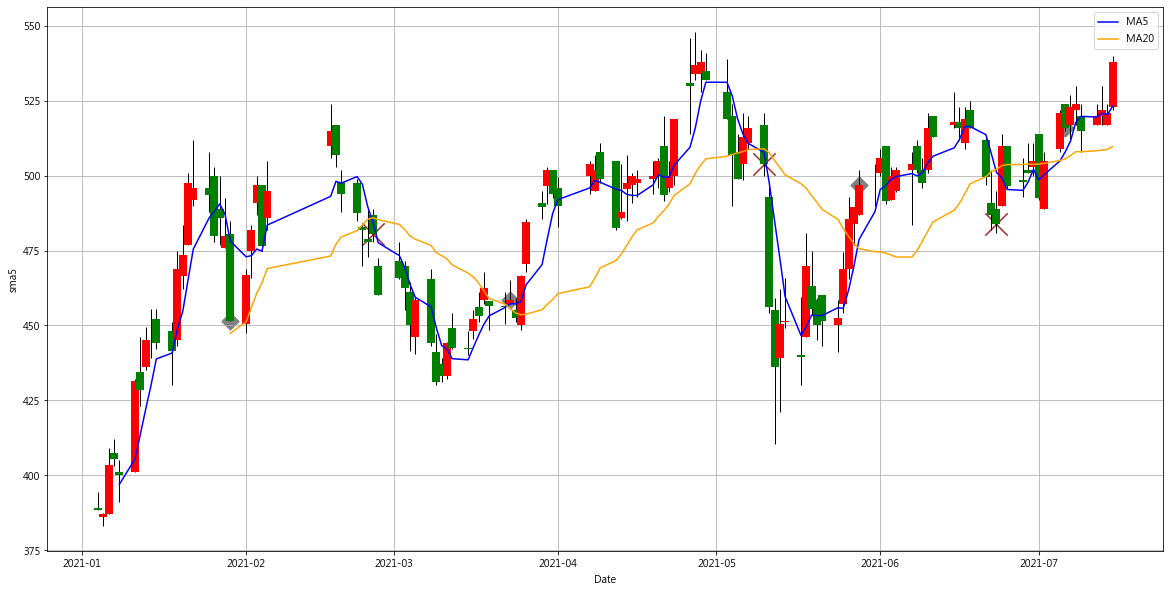

In [299]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
ohlc_plot(df, '')

sns.lineplot(x=sma5.index, y='sma5', data=sma5 , color='b', label='MA5')
sns.lineplot(x=sma20.index, y='sma20', data=sma20, color='orange', label='MA20')
plt.scatter(df.index, signal_buy, c='grey', marker='D', s=150)
plt.scatter(df.index, signal_sell, c='brown', marker='x', s=500)


In [300]:
# 計算損益(profit/loss)
# handling_fee：手續費率 0.1425% (買進/賣出 都要扣)
# transaction fee：證券交易稅 0.003% (賣出 才要扣)
# allow_oversold：是否允許超賣
def calc_profit(df_buy, df_sell, df, allow_oversold = True, handling_fee=0.001425, transaction_fee=0.003):
    df_profit = df_buy.merge(df_sell, on='date', how='outer') 
    df_profit.sort_values(by='date', inplace=True)

    df_date = df

    balance=0
    profit=0
    cost=0
    for index, row in df_profit.iterrows():
        # 買一股
        if not np.isnan(row['signal_buy']):
            balance+=1
            cost+=df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee)
        # 賣一股
        elif not np.isnan(row['signal_sell']):
            # 有部位
            if balance>0:
                avg_cost = cost / balance
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost
                cost -= avg_cost
            else: # 超賣
                # 不允許超賣
                if not allow_oversold:
                    continue    
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee)

            balance-=1

    if balance>0:   # 賣出平倉
        profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) * balance - cost
    elif balance<0: # 買進平倉
        profit += df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee) 
    
    return profit
    
def generate_profit_report(df_buy, df_sell, df, allow_oversold = True, handling_fee=0.001425, transaction_fee=0.003):   
    df_profit = df_buy.merge(df_sell, on='date', how='outer') 
    df_profit.sort_values(by='date', inplace=True)

    df_date = df

    balance=0
    profit=0
    cost=0
    first_transaction_amount = 0
    total_transaction_amount = 0
    total_handling_fee = 0
    total_transaction_fee = 0
    win_count = 0
    loss_count = 0
    max_net_val = 0
    min_net_val = 9999999999999
    for index, row in df_profit.iterrows():
        # 買一股
        if not np.isnan(row['signal_buy']):
            balance+=1
            cost+=df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee)
            total_transaction_amount += df_date.loc[row['date'], 'Adj Close'] 
            total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
            if first_transaction_amount==0:
                first_transaction_amount = df_date.loc[row['date'], 'Adj Close']
        # 賣一股
        elif not np.isnan(row['signal_sell']):
            # 有部位
            if balance>0:
                avg_cost = cost / balance
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost
                if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost > 0:
                    win_count+=1
                else: #if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - avg_cost < 0:
                    loss_count+=1
                cost -= avg_cost
                total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
                total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
                total_transaction_fee += df_date.loc[row['date'], 'Adj Close'] * transaction_fee
            else: # 超賣
                # 不允許超賣
                if not allow_oversold:
                    continue    
                profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee)
                total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
                total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
                total_transaction_fee += df_date.loc[row['date'], 'Adj Close'] * transaction_fee

            balance-=1
            
        net_val = df_date.loc[row['date'], 'Adj Close'] * balance
        if balance <= 0:
            net_val = profit
        if net_val > max_net_val:
            max_net_val = net_val
        if net_val < min_net_val:
            min_net_val = net_val

    if balance>0:   # 賣出平倉
        profit += df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) * balance - cost
        total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
        total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
        total_transaction_fee += df_date.loc[row['date'], 'Adj Close'] * transaction_fee
        if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - cost > 0:
            win_count+=1
        else: #if df_date.loc[row['date'], 'Adj Close']*(1-handling_fee-transaction_fee) - cost <= 0:
            loss_count+=1
    elif balance<0: # 買進平倉
        profit += df_date.loc[row['date'], 'Adj Close'] * (1+handling_fee) 
        total_transaction_amount +=df_date.loc[row['date'], 'Adj Close']
        total_handling_fee += df_date.loc[row['date'], 'Adj Close'] * handling_fee
    
    item_name=[]
    item_summary=[]
    
    item_name.append('總交易績效')
    item_summary.append(profit)
    item_name.append('買進次數')
    item_summary.append(df_buy.shape[0])
    item_name.append('賣出次數')
    item_summary.append(df_sell.shape[0])
    item_name.append('平均交易績效')
    item_summary.append(f'{profit/df_buy.shape[0]* 100:.2f}')
    item_name.append('平均報酬率')
    item_summary.append(f'{((profit/df_buy.shape[0]) / first_transaction_amount) * 100:.2f}')
    item_name.append('總交易金額')
    item_summary.append(total_transaction_amount)
    item_name.append('總證券交易稅')
    item_summary.append(total_transaction_fee)
    item_name.append('總手續費')
    item_summary.append(total_handling_fee)
    item_name.append('勝率')
    item_summary.append(f'{win_count/(win_count+loss_count)*100:.2f}')
    item_name.append('最高淨值')
    item_summary.append(max_net_val)
    item_name.append('最低淨值')
    item_summary.append(min_net_val)
    
    profit_report = pd.DataFrame({'item_name':item_name, 'item_summary':item_summary})
#     profit_report.sort_values(by='item_name', inplace=True)

    return profit_report
    
    
report = generate_profit_report(df_buy, df_sell, df, False)   

print('Buy & Hold = '+ str(df_sell['signal_sell'][-1:].values.item() - df_buy['signal_buy'][:1].values.item()))
print()
print('Buy & Sell = '+ str(calc_profit(df_buy, df_sell, df, False)))
print()
print(report)
print()
print(df_buy)
print()
print(df_sell)

Buy & Hold = 32.5

Buy & Sell = 49.97831249999979

   item_name item_summary
0      總交易績效    49.978312
1       買進次數            4
2       賣出次數            3
3     平均交易績效      1249.46
4      平均報酬率         2.77
5      總交易金額       3907.5
6     總證券交易稅       5.9535
7       總手續費     5.568188
8         勝率        50.00
9       最高淨值        516.0
10      最低淨值      26.2304

          date  signal_buy
19  2021-01-29       451.5
48  2021-03-23       458.5
92  2021-05-28       497.0
118 2021-07-06       516.0

          date  signal_sell
31  2021-02-25        480.5
78  2021-05-10        504.0
109 2021-06-23        484.0


In [301]:
from prophet import Prophet

df1 = df.reset_index()
df2 = df1[['Date', 'Adj Close']].copy()
df2.columns = ['ds', 'y']

model = Prophet(changepoint_prior_scale=1)
model.fit(df2)

future = model.make_future_dataframe(periods=10)
forecast = model.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


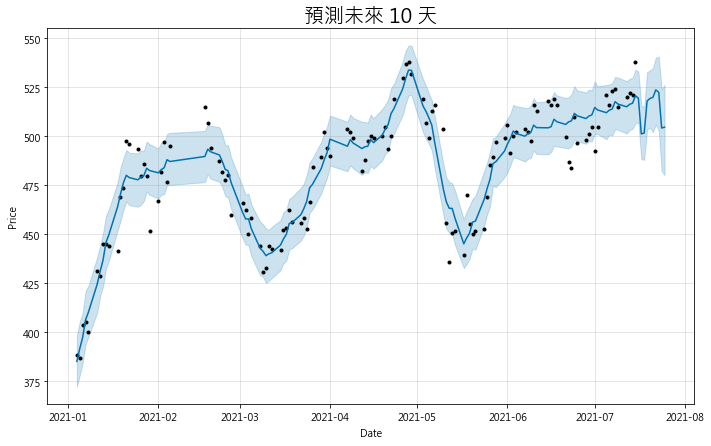

In [302]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

font = {'family': 'Microsoft JhengHei', 'weight': 'normal', 'size': 20}
fig = model.plot(forecast, xlabel='Date', ylabel=r'Price')
plt.title('預測未來 10 天', fontdict=font)
plt.show()

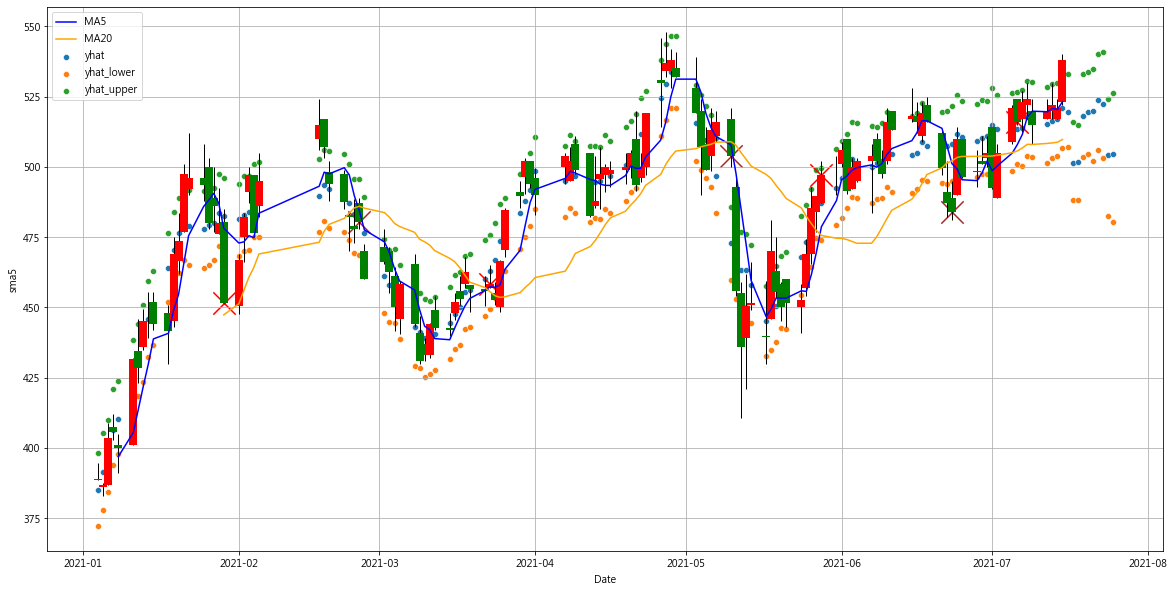

In [303]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
ohlc_plot(df, '')

sns.lineplot(x=sma5.index, y='sma5', data=sma5 , color='b', label='MA5')
sns.lineplot(x=sma20.index, y='sma20', data=sma20, color='orange', label='MA20')
sns.scatterplot(x="ds", y="yhat",data=forecast, label='yhat')
sns.scatterplot(x="ds", y="yhat_lower",data=forecast, label='yhat_lower')
sns.scatterplot(x="ds", y="yhat_upper",data=forecast, label='yhat_upper')
plt.scatter(df.index, signal_buy, c='red', marker='x', s=500)
plt.scatter(df.index, signal_sell, c='brown', marker='x', s=500)
